In [1]:
#Environment Details
# !python --version
# !pip freeze

#Use when not running in Colab
# !pip install numpy==1.18.5
# !pip install tensorflow==2.3.0
# !pip install pandas==1.0.5
# !pip install seaborn==0.10.1
# !pip install matplotlib==3.2.2
# !pip install sklearn==0.0
# !pip install scipy==1.4.1

In [2]:
#Pre-requisites
!nvidia-smi
!pip install gdown
!pip install tensorflow-gpu

#Let’s download the data
#!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
#!tar -xvf WISDM_ar_latest.tar.gz
!gdown https://cdap-fmg.s3.us-east-2.amazonaws.com/WISDM_WATCH_ACCEL.txt

Sun Sep 13 07:55:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The data has the following features:
* user_id - unique identifier of the user doing the activity
* activity - the category of the current activity
* x_axis, y_axis, z_axis - accelerometer data for each axis

In [4]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('WISDM_WATCH_ACCEL.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

# removing the 'timestamp' column.
df.pop('timestamp')

df.head() #Outputs the first few lines of Data
#df.shape #Outputs number of rows and collumns

,user_id,activity,x_axis,y_axis,z_axis
0,1600,Walking,7.091625,-0.591667,8.195502
1,1600,Walking,4.972757,-0.158317,6.696732
2,1600,Walking,3.253720,-0.191835,6.107758
3,1600,Walking,2.801216,-0.155922,5.997625
4,1600,Walking,3.770868,-1.051354,7.731027


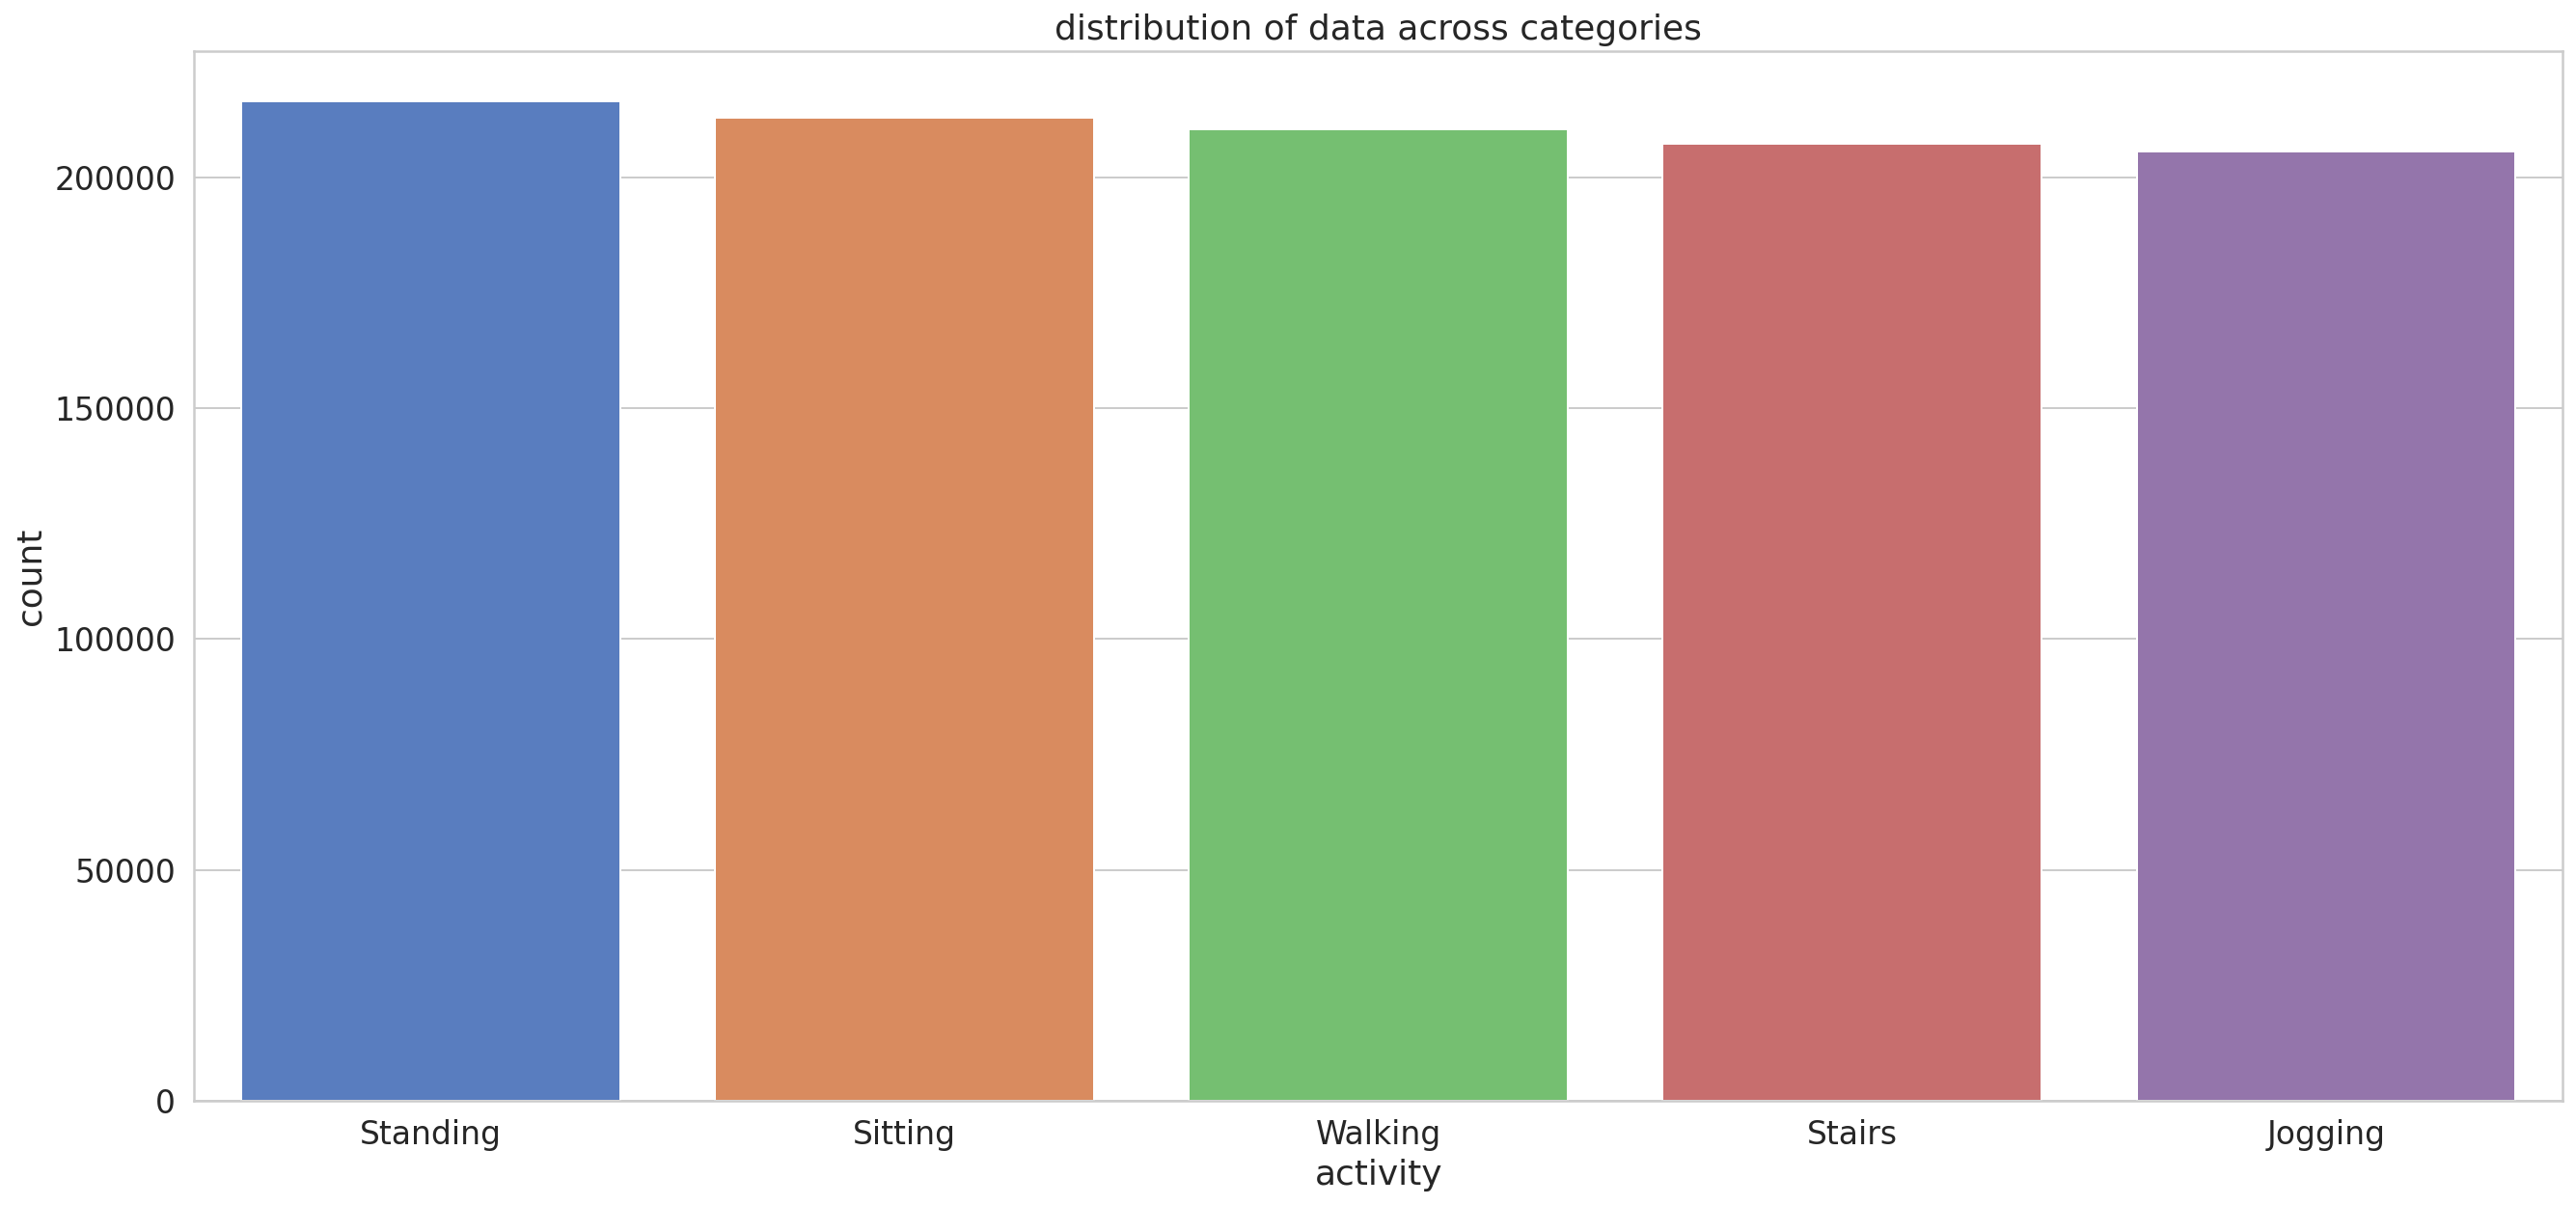

In [5]:
#Outputs the distribution of data
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);
plt.title("distribution of data across categories");

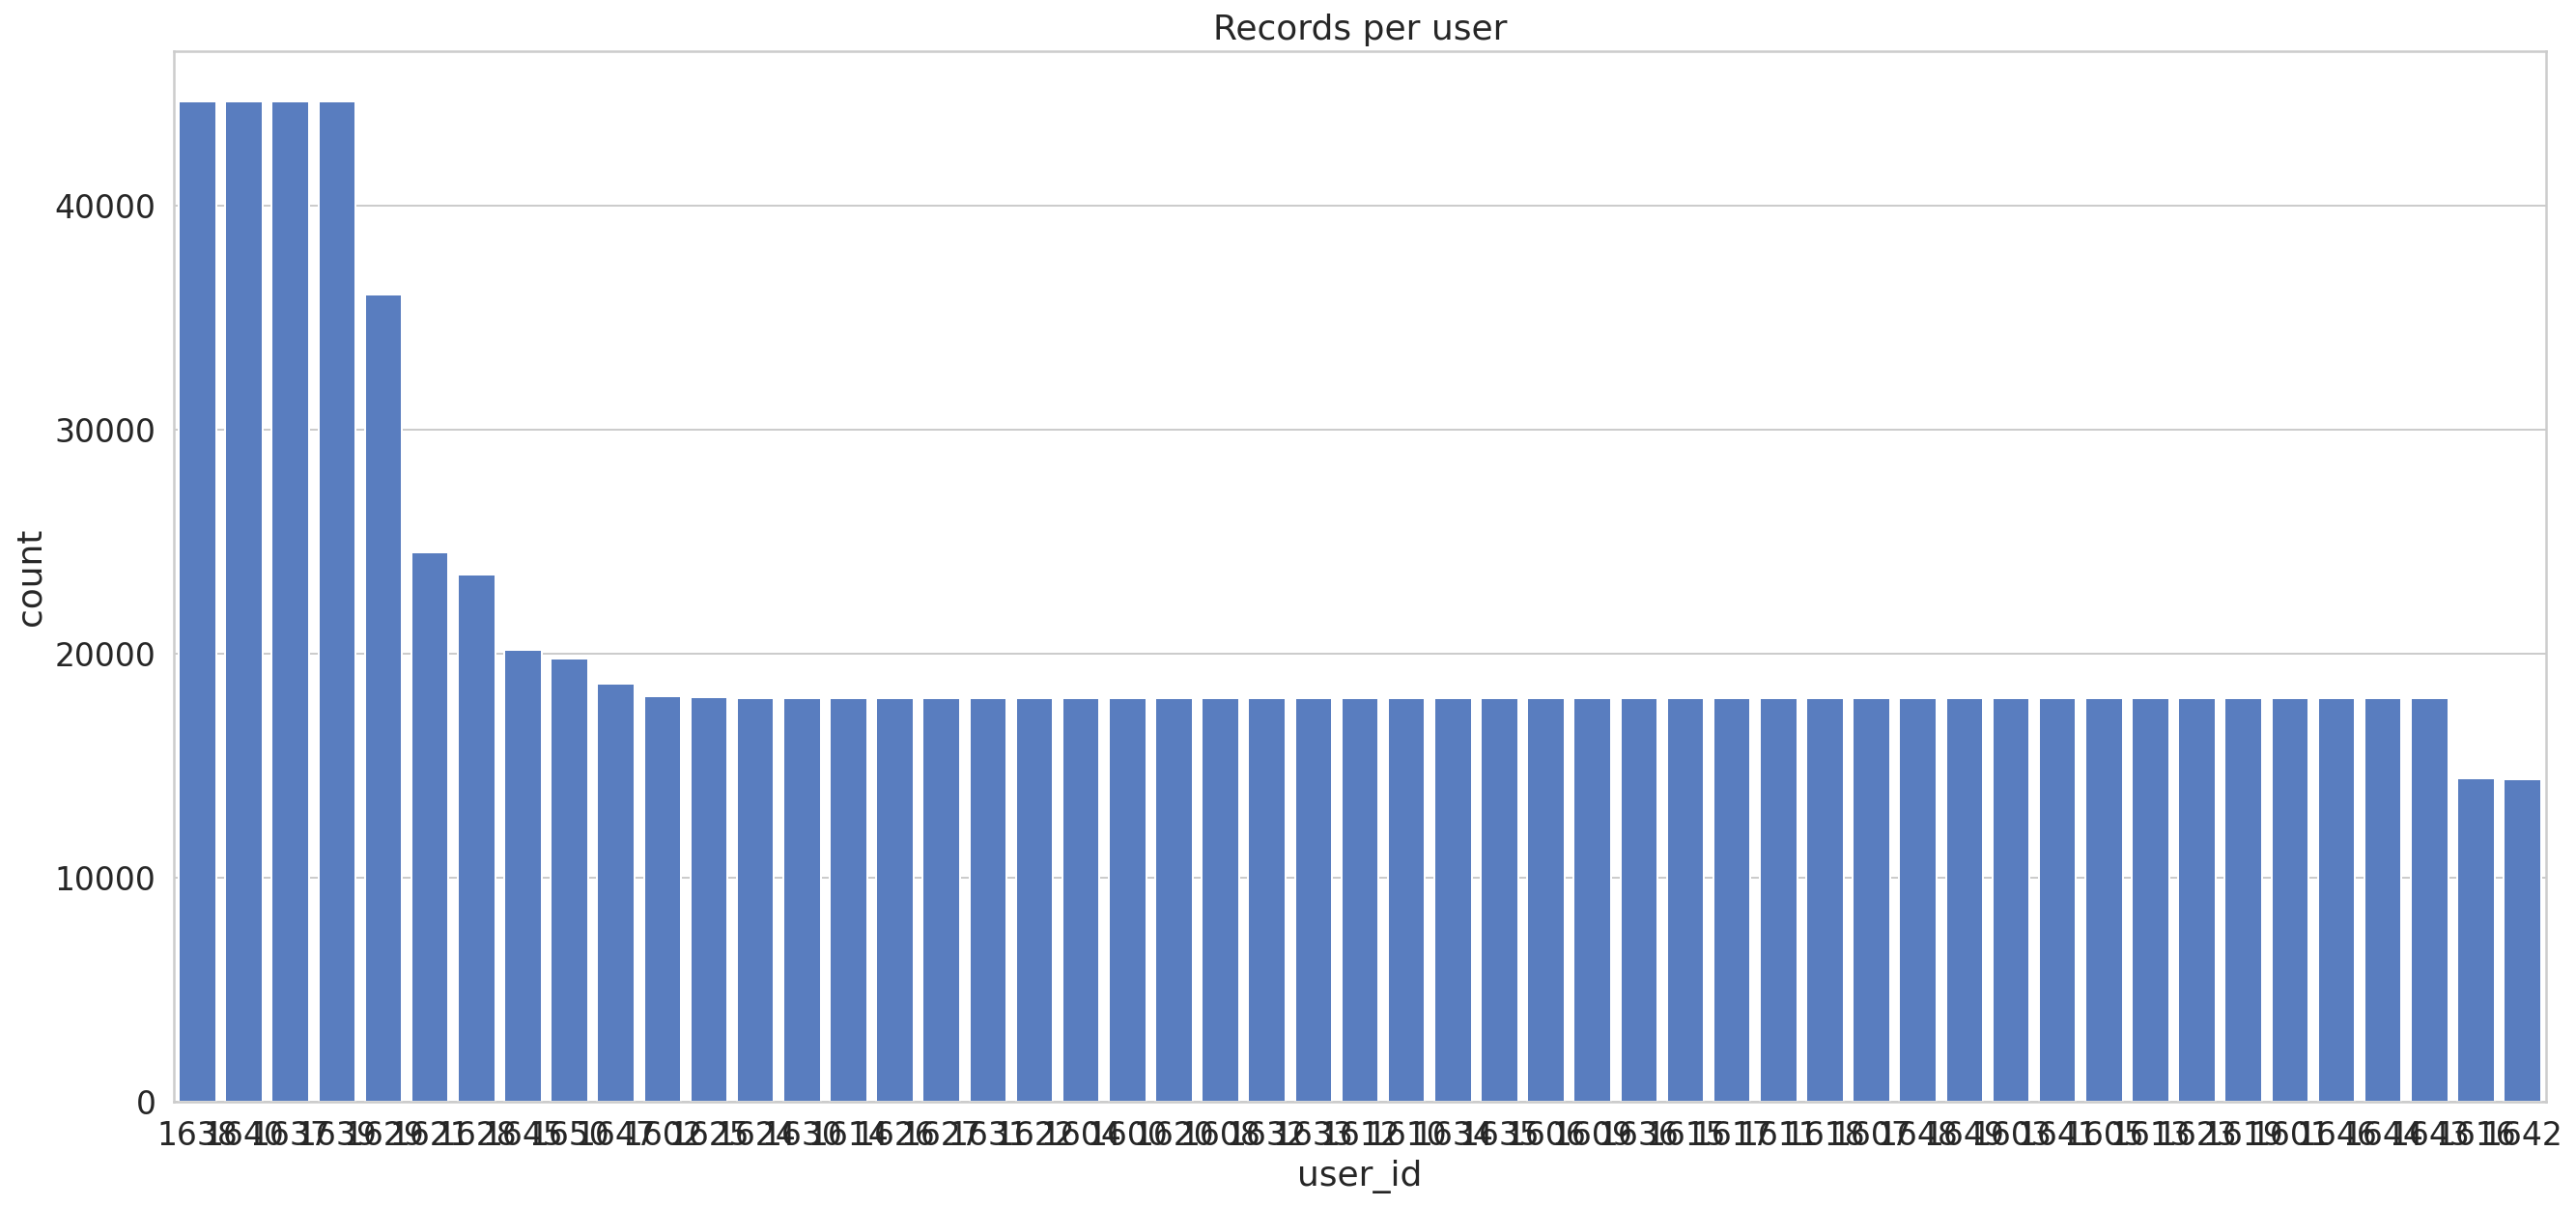

In [6]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [7]:
#Observing the first 200 records
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

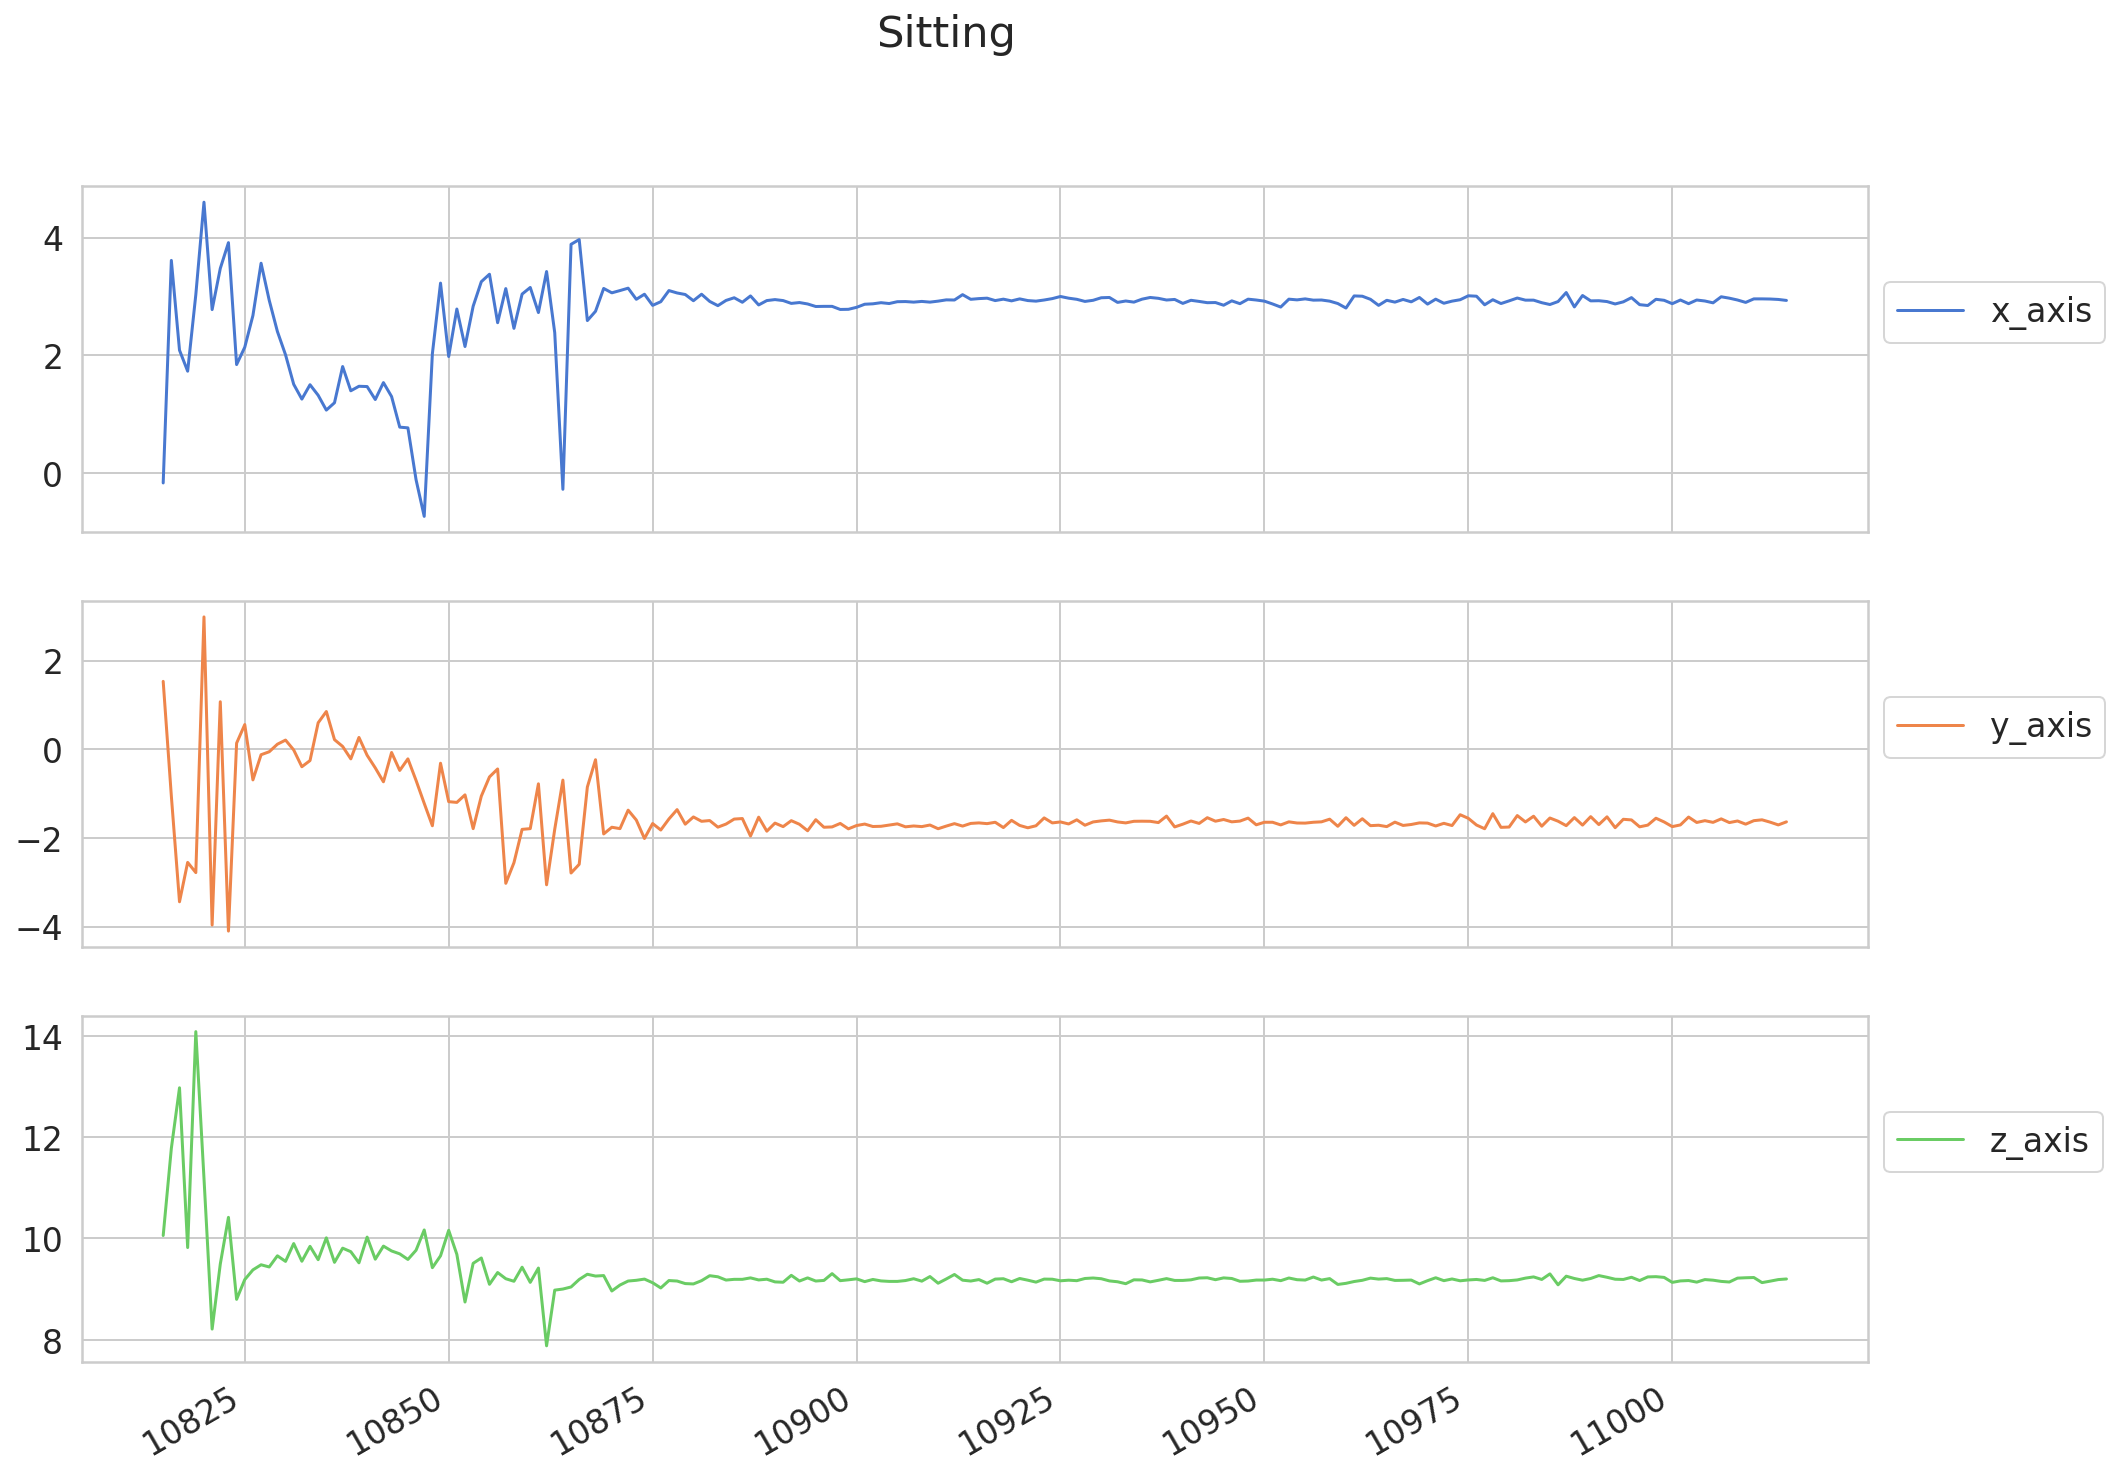

In [8]:
plot_activity("Sitting", df);

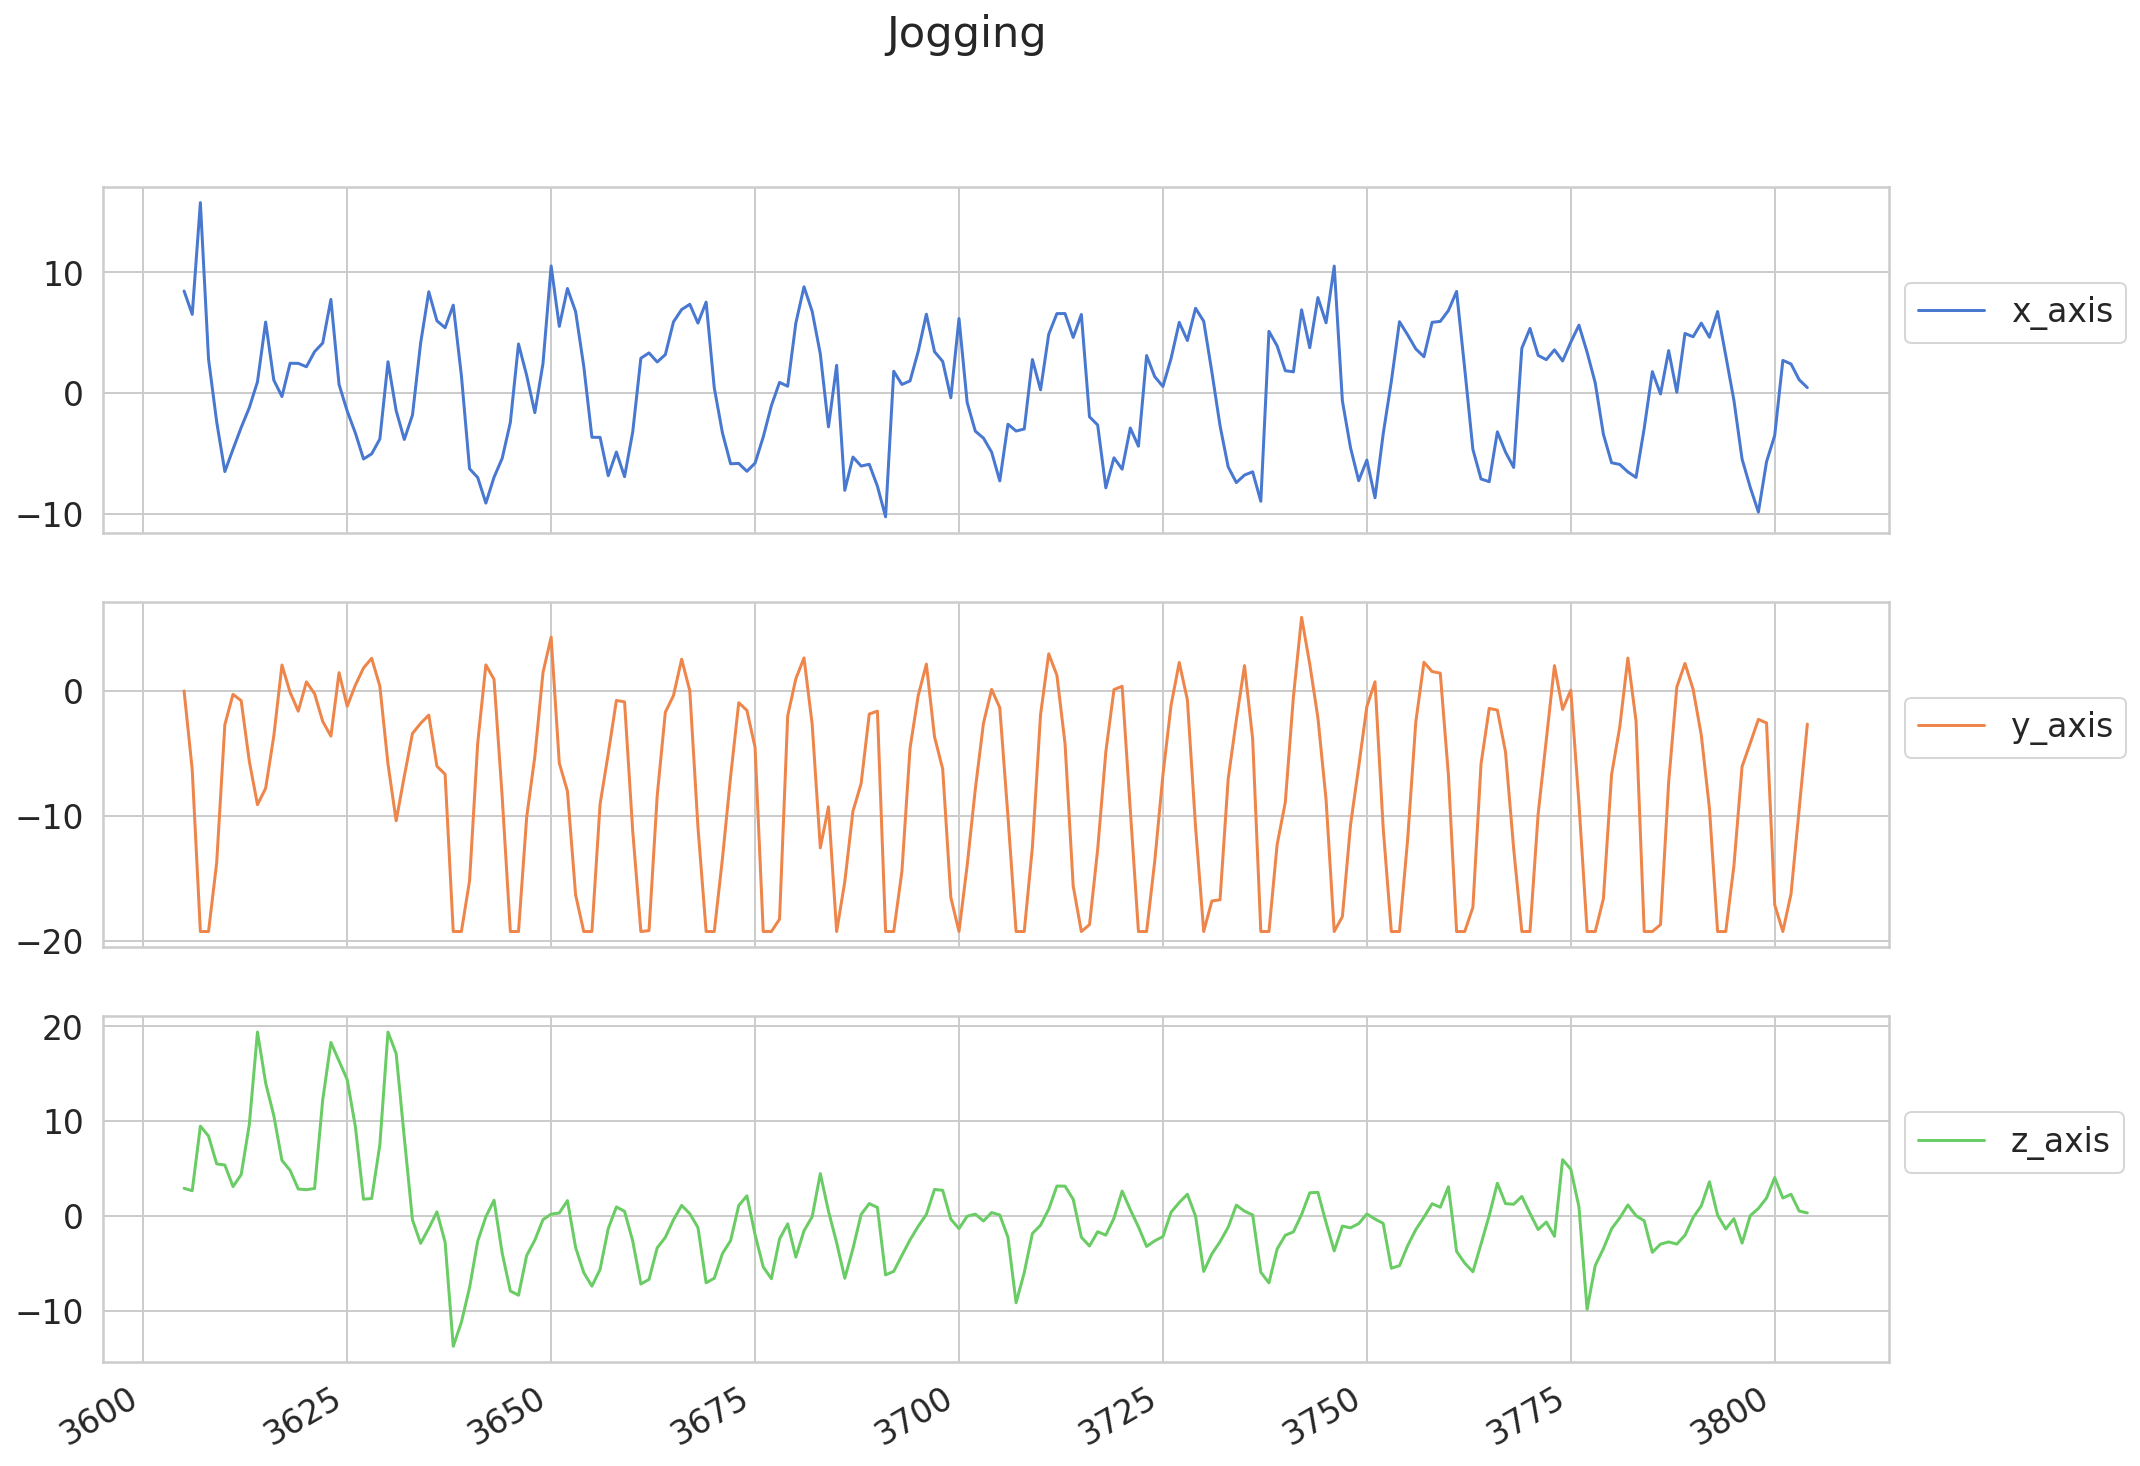

In [9]:
plot_activity("Jogging", df);

spliting the data into training and test datasets.

In [10]:
df_train = df[df['user_id'] <= 1640]
df_test = df[df['user_id'] > 1640]

Next, we’ll scale the accelerometer data values:

In [11]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [12]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [13]:
print(X_train.shape, y_train.shape)

(21797, 200, 3) (21797, 1)


In [14]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [15]:
print(X_train.shape, y_train.shape)

(21797, 200, 3) (21797, 5)


In [16]:
# The model is defined as a Sequential Keras model, for simplicity.
# We will define the model as having a single LSTM hidden layer. 
# This is followed by a dropout layer intended to reduce overfitting of the model to the training data. 
# Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, 
# before a final output layer is used to make predictions.


model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


In [17]:
# one epoch = one forward pass and one backward pass of all the training examples
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.
# number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass

history = model.fit(
    X_train, y_train,
    epochs=300,   
                    # 20,32 -> 0.7247 ; 60,32 -> 0.7873; 100,32 -> 0.8768 ; 200,32 -> 0.9067 ; 300,32 -> 0.9195
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
)

Epoch 1/300
614/614 [==============================] - 59s 97ms/step - loss: 1.3581 - acc: 0.3900 - val_loss: 1.2292 - val_acc: 0.4541
Epoch 2/300
614/614 [==============================] - 58s 95ms/step - loss: 1.0607 - acc: 0.4910 - val_loss: 1.3160 - val_acc: 0.3569
Epoch 3/300
614/614 [==============================] - 55s 90ms/step - loss: 1.0350 - acc: 0.5253 - val_loss: 1.1841 - val_acc: 0.5459
Epoch 4/300
614/614 [==============================] - 55s 89ms/step - loss: 0.9279 - acc: 0.5603 - val_loss: 0.9203 - val_acc: 0.6225
Epoch 5/300
614/614 [==============================] - 54s 88ms/step - loss: 1.1667 - acc: 0.5228 - val_loss: 1.6673 - val_acc: 0.4220
Epoch 6/300
614/614 [==============================] - 54s 88ms/step - loss: 1.0942 - acc: 0.4804 - val_loss: 1.4257 - val_acc: 0.4303
Epoch 7/300
614/614 [==============================] - 54s 87ms/step - loss: 1.0066 - acc: 0.5107 - val_loss: 1.2331 - val_acc: 0.4803
Epoch 8/300
614/614 [==============================] - 

In [18]:
# See how well can it predict the test data, second number is accuracy percentage
model.evaluate(X_test, y_test)

142/142 [==============================] - 4s 31ms/step - loss: 0.4508 - acc: 0.9272


[0.4507788419723511, 0.9272446036338806]

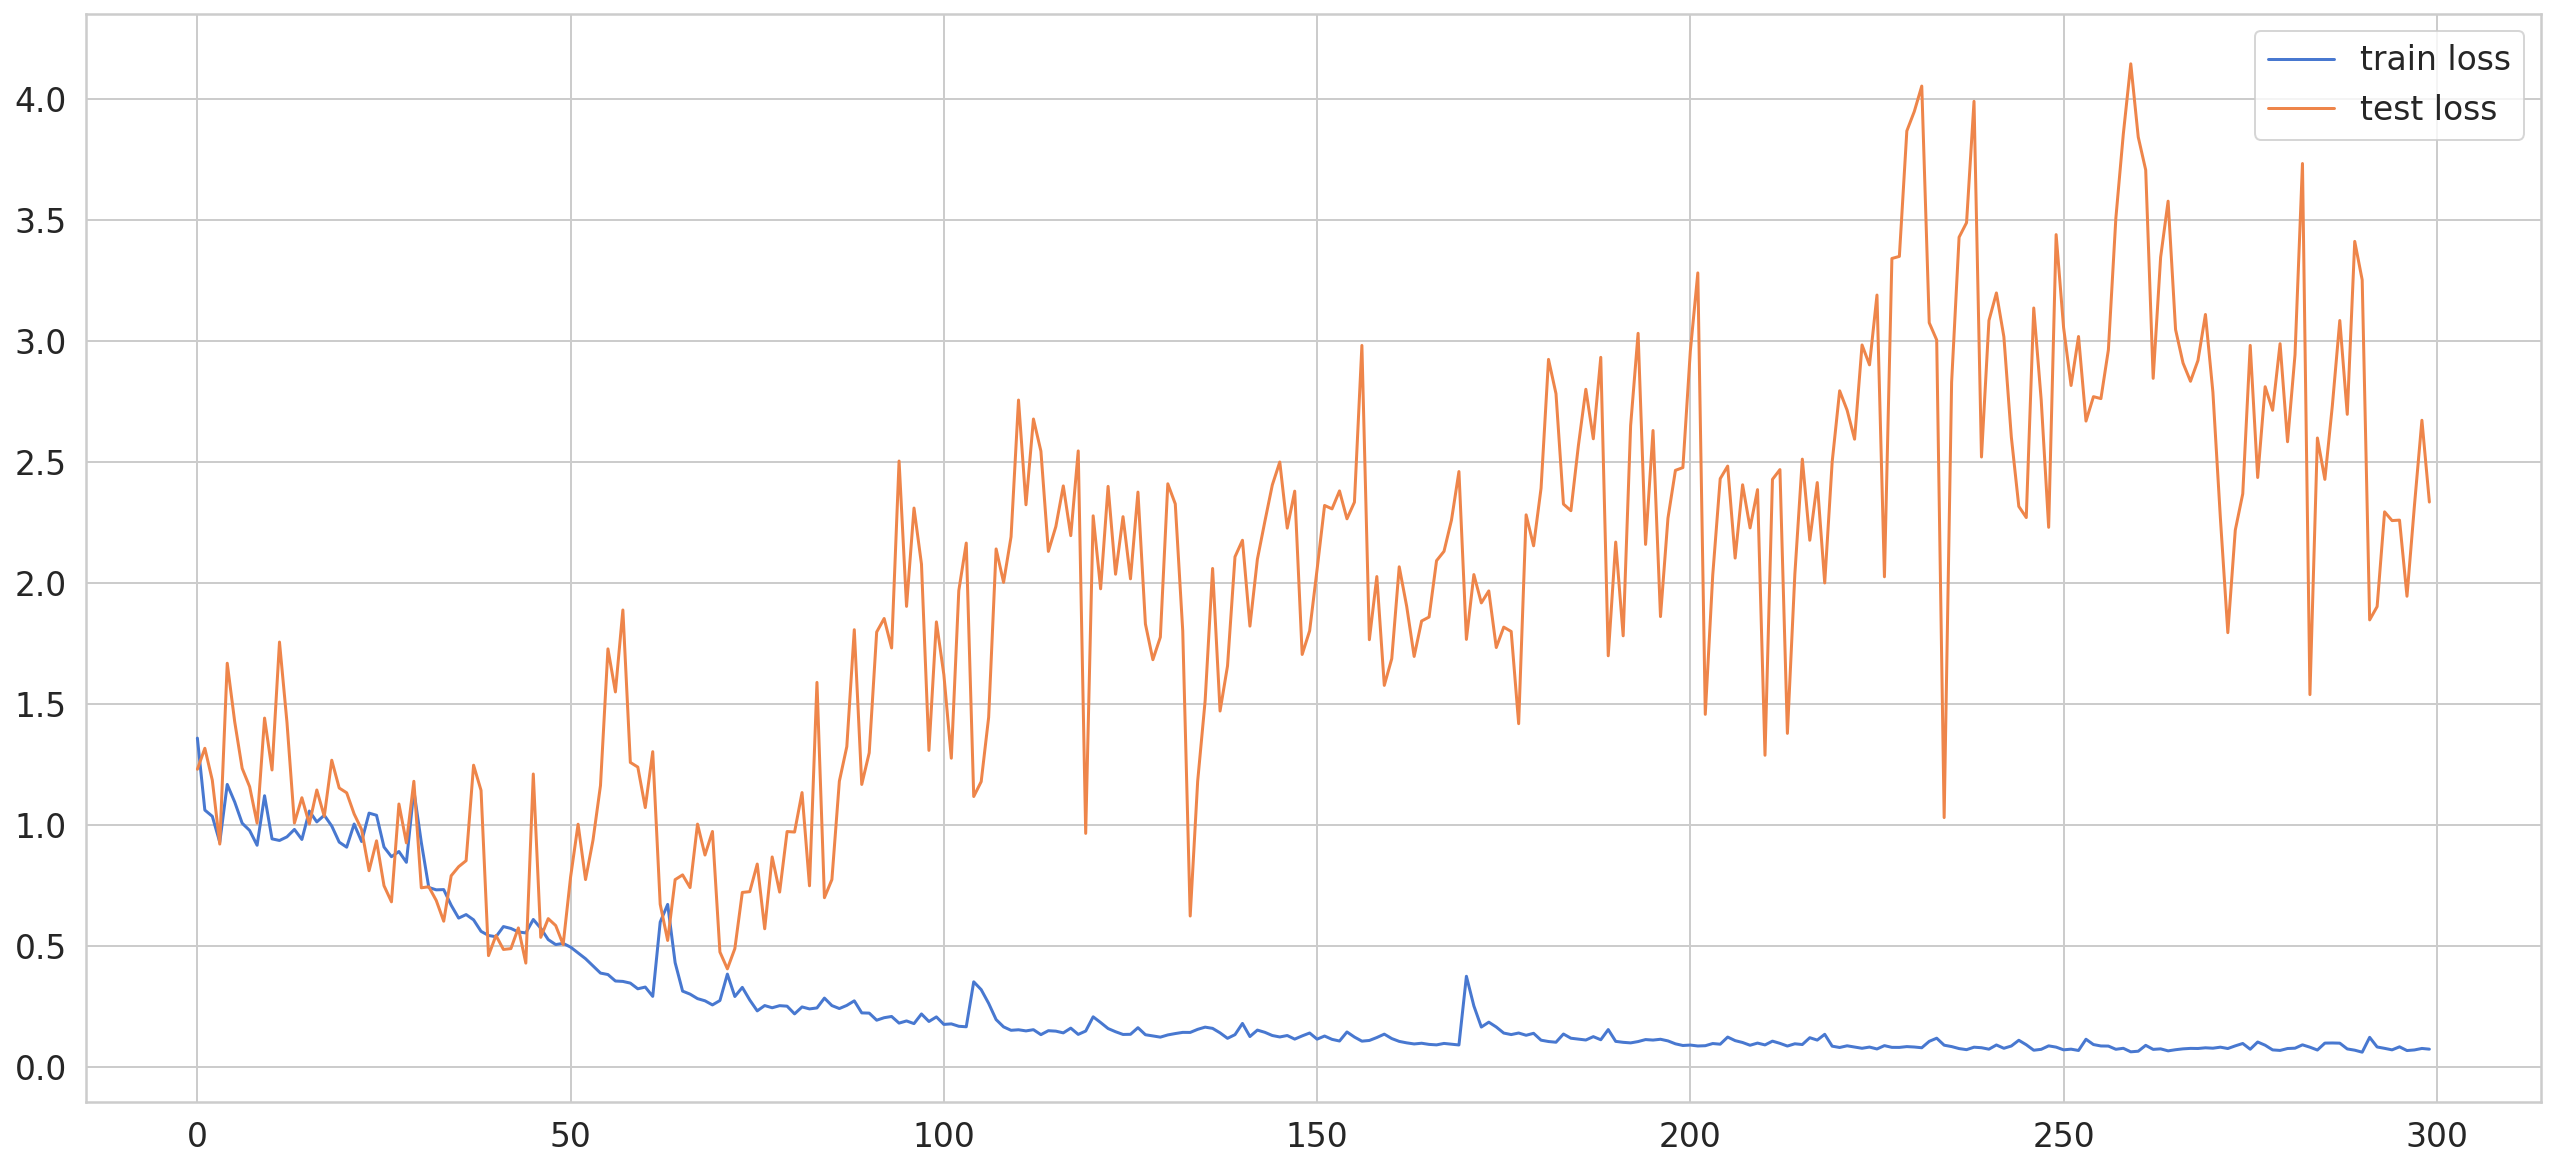

In [19]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend();

In [20]:
# print(X_test)
y_pred = model.predict(X_test)
print(y_pred)
# print(model.summary())

[[1.3115537e-13 1.8452466e-16 2.6728105e-07 4.4339870e-12 9.9999976e-01]
 [2.4557917e-08 2.4670248e-09 3.6837198e-04 1.0629518e-06 9.9963057e-01]
 [9.1199931e-10 1.2253995e-10 3.0403489e-05 4.1975760e-08 9.9996960e-01]
 ...
 [1.5818913e-24 4.6983051e-10 3.8220889e-12 1.0000000e+00 2.7381666e-10]
 [1.5243514e-24 4.5667828e-10 3.6987553e-12 1.0000000e+00 2.6575386e-10]
 [8.7229692e-20 5.1905062e-08 5.6687727e-10 1.0000000e+00 3.0874507e-08]]


In [21]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

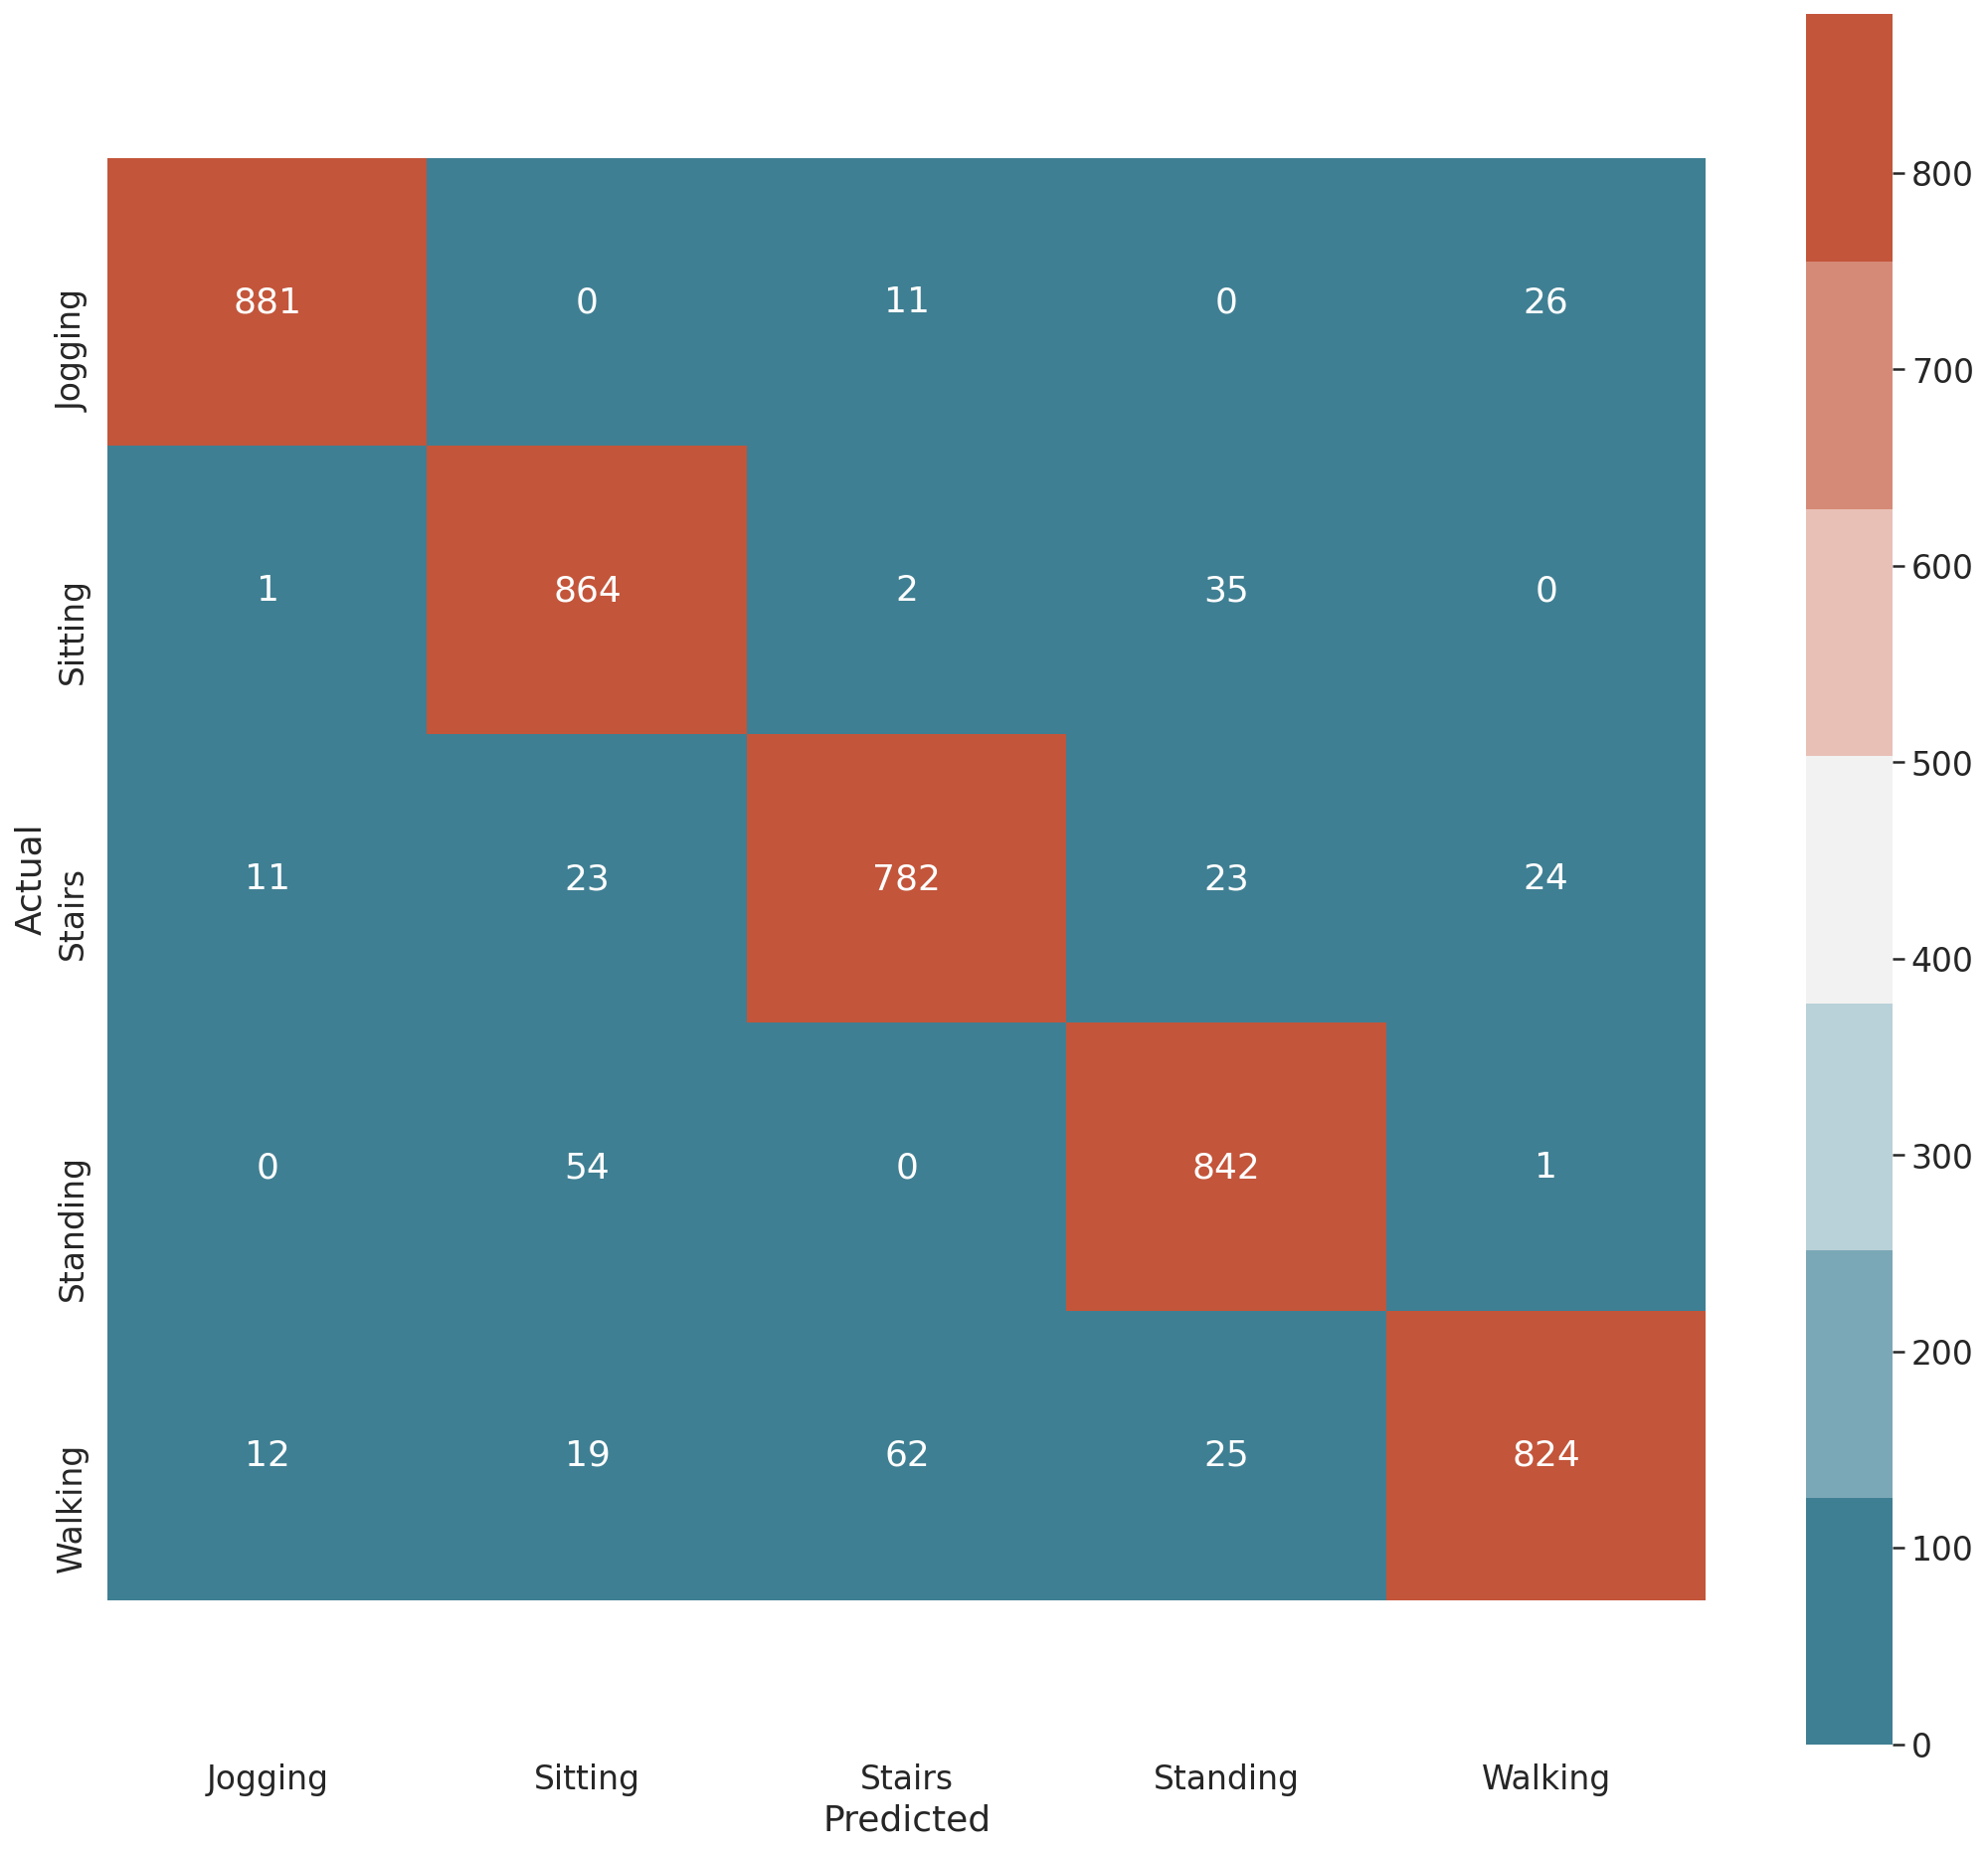

In [22]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)